Code referenced from:
https://pub.towardsai.net/multiclass-image-classification-hands-on-with-keras-and-tensoflow-e1cf434f3467

# Setup

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from keras.applications.xception import Xception
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
import random
import os
import glob
import cv2

In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [30]:
np.random.seed(0) 
tf.random.set_seed(0) 
random.seed(0)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
os.environ['TF_CUDNN_DETERMINISM'] = "1"
os.environ['PYTHONHASHSEED'] = str(0)

# Import Data

In [31]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [32]:
!unzip drive/MyDrive/CV/data.zip

Archive:  drive/MyDrive/CV/data.zip
replace data/Eczema/0_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [34]:
eczema = glob.glob("data/Eczema/*.jpg")
fungal = glob.glob("data/Fungal_Infections/*.jpg")
viral = glob.glob("data/Viral_Infections/*.jpg")

In [35]:
img_path = [x for x in eczema]
img_path.extend([x for x in fungal])
img_path.extend([x for x in viral])

df = pd.DataFrame(np.concatenate([['0']*len(eczema), ['1']*len(fungal), ['2']*len(viral)]), columns = ['label'])
df['image'] = [x for x in img_path]

# Create Image and Label Arrays

In [36]:
img_data = []
for i in img_path:
  path = os.path.join(i)
  img = cv2.imread(path) # get image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # fix color
  img = cv2.resize(img, (128,128)) # resize
  img_data.append(img)

X = np.array(img_data)

In [37]:
y = OneHotEncoder(dtype='int8', sparse_output=False).fit_transform(df['label'].values.reshape(-1,1))

In [38]:
print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

Shape of X:  (5482, 128, 128, 3)
Shape of y:  (5482, 3)


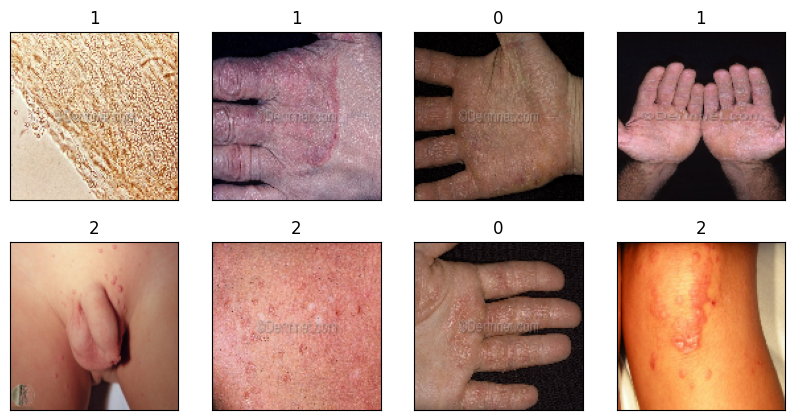

In [39]:
img_index = np.random.randint(0, X.shape[0], 8)
plot_index = 1
plt.figure(figsize=(10,5))
for i in img_index:
  plt.subplot(2,4,plot_index)
  plt.imshow(X[i])
  plt.title(df['label'].loc[i])
  plt.xticks([])
  plt.yticks([])
  plot_index += 1

# Split and Augment Data

In [40]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=0)

In [41]:
train_gen = ImageDataGenerator(horizontal_flip=True,
  rotation_range=45,
  zoom_range=0.2,
  height_shift_range=0.5,
  width_shift_range=0.5)
validation_gen = ImageDataGenerator(horizontal_flip=True,
  rotation_range=45,
  zoom_range=0.2,
  height_shift_range=0.5,
  width_shift_range=0.5)

train_gen.fit(X_train)
validation_gen.fit(X_val)

# Create and Run DL Model

In [42]:
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
head = Dense(3, activation='softmax')(x) # Since 3 classes
model = Model(inputs=base.input, outputs=head)

model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 add_15 (Add)                   (None, 8, 8, 728)    0           ['block5_sepconv3_bn[0][0]',     
                                                                  'add_14[0][0]']                 
                                                                                                  
 block6_sepconv1_act (Activatio  (None, 8, 8, 728)   0           ['add_15[0][0]']                 
 n)                                                                                               
                                                                                                  
 block6_sepconv1 (SeparableConv  (None, 8, 8, 728)   536536      ['block6_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block6_se

In [43]:
# Change these params for best fit (set epoch = 0 to load model)
batch_size = 128
epochs = 0

if epochs == 0:
  model = load_model('drive/MyDrive/CV/myclassifier25')
else:
  history = CSVLogger('drive/MyDrive/CV/training25.log', separator=',', append=False)
  model.fit(train_gen.flow(X_train, y_train, batch_size=batch_size),
            epochs=epochs, validation_data=validation_gen.flow(X_val, y_val), 
            callbacks=[history])
  model.save(os.path.join('drive/MyDrive/CV', 'myclassifier25'))

# Evaluate Results

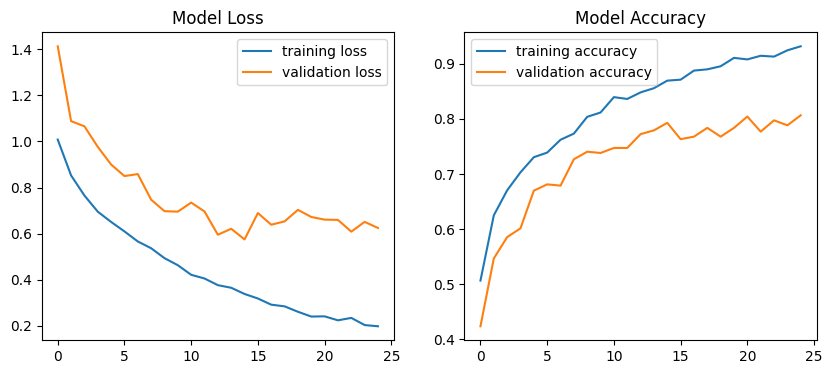

In [44]:
history = pd.read_csv('drive/MyDrive/CV/training25.log', sep=',', engine='python')
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history['loss'], label='training loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='training accuracy')
plt.plot(history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend();

In [45]:
test_results = model.evaluate(X_test, y_test) # test loss & accuracy

35/35 [==============================] - 3s 49ms/step - loss: 0.6934 - accuracy: 0.8131


35/35 [==============================] - 3s 48ms/step


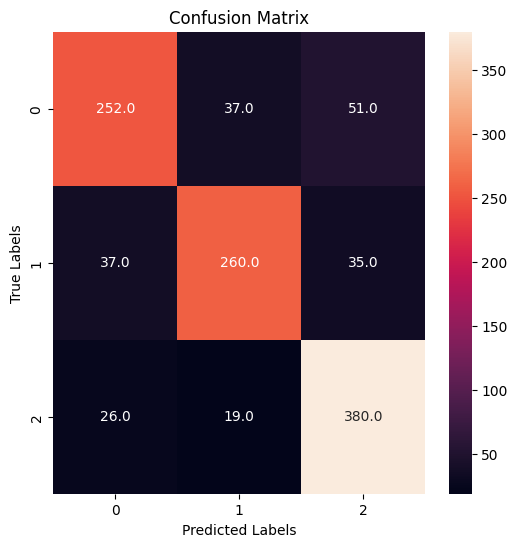

In [46]:
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(true_label, pred_label)

f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='.1f', ax=ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [47]:
print(classification_report(true_label, pred_label))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       340
           1       0.82      0.78      0.80       332
           2       0.82      0.89      0.85       425

    accuracy                           0.81      1097
   macro avg       0.81      0.81      0.81      1097
weighted avg       0.81      0.81      0.81      1097



# Use Model on Outside Photos

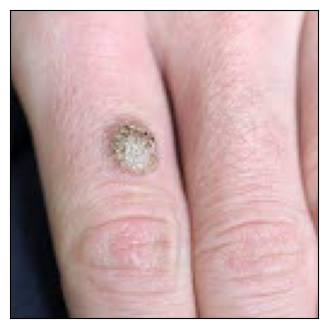

In [49]:
img = cv2.imread('drive/MyDrive/CV/WartTestImage.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (128,128))

plt.figure(figsize=(4,4))
plt.imshow(img_resized)
plt.xticks([])
plt.yticks([])
plt.show()

In [50]:
yhat = model.predict(np.expand_dims(img_resized/255, 0))
print(yhat)

label = np.argmax(yhat)
if label == 0:
  print('Predicted: Ezcema')
elif label == 1:
  print('Predicted: Funagl Infection')
else:
  print('Predicted: Viral Infection')

1/1 [==============================] - 2s 2s/step
[[0.38983268 0.20700872 0.4031586 ]]
Predicted: Viral Infection
